In [32]:
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import cv2
import os
import PIL
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [6]:
data_path="Desktop/New Masks Dataset/Train"
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]
labels_dict=dict(zip(categories,labels))
print(labels_dict)
print(categories)
print(labels)

{'Mask': 0, 'Non Mask': 1}
['Mask', 'Non Mask']
[0, 1]


In [7]:
img_size=100
data=[]
target=[]
for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)

    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        
        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            resized=cv2.resize(gray,(img_size,img_size))
            data.append(resized)
            target.append(labels_dict[category])
        except Exception as e:
            print("Exception: ",e)
            
    

In [8]:
len(data)

700

In [9]:
len(target)

700

In [10]:
data1=np.array(data)/255
data2=np.reshape(data1,(data1.shape[0],img_size,img_size,1))
data2.shape

(700, 100, 100, 1)

In [11]:
target=np.array(target)
target.shape

(700,)

In [12]:

from keras.utils import np_utils
new_target=np_utils.to_categorical(target)
target.shape

(700,)

In [13]:
np.save("data2",data)
np.save("target",new_target)

In [14]:
data=np.load("data2.npy")
target=np.load("target.npy")

In [15]:
data2.shape

(700, 100, 100, 1)

In [16]:
new_target.shape

(700, 2)

In [17]:
model=keras.Sequential([
    layers.Conv2D(filters=200,kernel_size=(3,3),activation="relu",input_shape=data2.shape[1:]),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=180,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(200,activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(50,activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(10,activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(5,activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(2,activation="softmax")
])
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 200)       2000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 180)       324180    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 180)       0         
_________________________________________________________________
flatten (Flatten)            (None, 95220)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               19044200  
_________________________________________________________________
dropout (Dropout)            (None, 200)               0

Val_loss is value for cross-validation data and loss is value for cost function

In [18]:
checkpoint=ModelCheckpoint(filepath="Desktop/New Masks Dataset/New folder",monitor="val_loss",verbose=0,save_best_only=True,mode="auto")
history=model.fit(data2,new_target,epochs=15,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 1.3596 - accuracy: 0.5589WARNING:tensorflow:From C:\Mba notes\novels\Anaconda\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Desktop/New Masks Dataset\New folder\assets
18/18 [==============================] - 55s 3s/step - loss: 1.3596 - accuracy: 0.5589 - val_loss: 1.1582 - val_accuracy: 0.0000e+00
Epoch 2/15
18/18 [==============================] - 45s 2s/step - loss: 0.9480 - accuracy: 0.5750 - val_loss: 1.1824 - val_accuracy: 0.2214
Epoch 3/15
18/18 [==============================] - 55s 3s/step - loss: 0.7

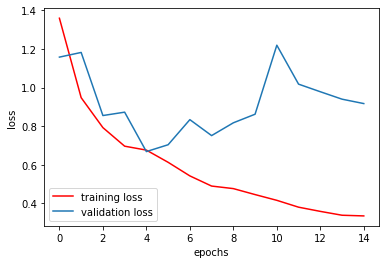

In [19]:
plt.plot(history.history["loss"],"r",label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

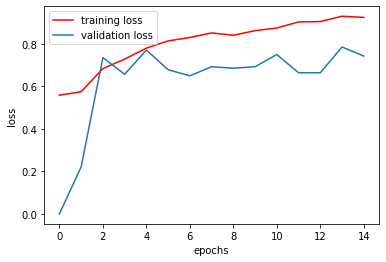

In [20]:
plt.plot(history.history["accuracy"],"r",label="training loss")
plt.plot(history.history["val_accuracy"],label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [34]:
model.save("Desktop/New Masks Dataset/model_for_mask_detection")

INFO:tensorflow:Assets written to: Desktop/New Masks Dataset/model_for_mask_detection\assets


In [35]:
model=load_model("Desktop/New Masks Dataset/model_for_mask_detection")

In [36]:
face_clsfr=cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
source=cv2.VideoCapture(0)
labels_dict={0:"MASK",1:"NO MASK"}
color_dict={0:(0,255,0),1:(0,0,255)}

In [37]:
while(True):
    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)
    
    for x,y,w,h in faces:
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)
        
        label=np.argmax(result,axis=1)[0]
        
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img,labels_dict[label],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    cv2.imshow("LIVE",img)
    key=cv2.waitKey(1)
    
    if(key==ord("q")):
        break
cv2.destroyAllWindows()
source.release()

        
        

# Face mask Detection 2

In [2]:
import cv2
import os

In [17]:
data_dir="Desktop/New Masks Dataset/Train"
category=os.listdir(data_dir)
list=[i for i in range(len(category))]
labels_dict=dict(zip(category,list))

print(labels_dict)

{'Mask': 0, 'Non Mask': 1}


In [19]:
print(dict((category,list)))

{'Mask': 'Non Mask', 0: 1}


In [35]:
data=[]
target=[]
for i in category:
    # here i will get two path one for mask and other for non-mask.Basically it is going inside category on mask and
    #non-mask folder
    folder_path=os.path.join(data_dir,i)
    # here it goes in all photos in mask and and non-mask folder
    img_name=os.listdir(folder_path)
    print(folder_path)
    for j in img_name:
        img_path=os.path.join(folder_path,j)
        img=cv2.imread(img_path)
        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            resize=cv2.resize(gray,(100,100))
            data.append(resize)
            target.append(labels_dict[i])
        except Exception as e:
            print("Exception: ",e)

Desktop/New Masks Dataset/Train\Mask
Desktop/New Masks Dataset/Train\Non Mask


In [39]:
data1=np.array(data)/255
data1.shape
        

(700, 100, 100)

In [41]:
data2=data1.reshape(-1,100,100,1)
data2.shape

(700, 100, 100, 1)

In [43]:
target=np.array(target)
target.shape

(700,)

In [63]:
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

In [96]:

model=keras.Sequential([
    layers.Conv2D(filters=200,kernel_size=(2,2),activation="relu",input_shape=(100,100,1)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=100,kernel_size=(2,2),activation="relu",input_shape=data2.shape),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(300,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(100,activation="relu"),
    layers.Dense(30,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10,activation="relu"),
    layers.Dense(2,activation="softmax")
])
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(data2,new_target,epochs=15,validation_split=0.2)

Epoch 1/15
18/18 [==============================] - 21s 1s/step - loss: 0.6849 - accuracy: 0.6107 - val_loss: 0.8155 - val_accuracy: 0.0071
Epoch 2/15
18/18 [==============================] - 20s 1s/step - loss: 0.5117 - accuracy: 0.7536 - val_loss: 0.4265 - val_accuracy: 0.8500
Epoch 3/15
18/18 [==============================] - 20s 1s/step - loss: 0.3852 - accuracy: 0.8482 - val_loss: 0.4809 - val_accuracy: 0.7643
Epoch 4/15
18/18 [==============================] - 20s 1s/step - loss: 0.3776 - accuracy: 0.8393 - val_loss: 0.5991 - val_accuracy: 0.6357
Epoch 5/15
18/18 [==============================] - 20s 1s/step - loss: 0.2929 - accuracy: 0.8875 - val_loss: 0.5534 - val_accuracy: 0.7071
Epoch 6/15
18/18 [==============================] - 20s 1s/step - loss: 0.2421 - accuracy: 0.9143 - val_loss: 0.5780 - val_accuracy: 0.7214
Epoch 7/15
18/18 [==============================] - 20s 1s/step - loss: 0.1708 - accuracy: 0.9464 - val_loss: 0.7768 - val_accuracy: 0.6786
Epoch 8/15
18/18 [==

In [82]:
checkpoint=ModelCheckpoint(filepath="Desktop/New Masks Dataset/New folder",monitor="val_loss",vebose=0,save_best_only=True,mode="auto")
history=model.fit(data2,new_target,epochs=15,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.6268WARNING:tensorflow:From C:\Mba notes\novels\Anaconda\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Desktop/New Masks Dataset\New folder\assets
18/18 [==============================] - 26s 1s/step - loss: 0.6337 - accuracy: 0.6268 - val_loss: 0.9313 - val_accuracy: 0.0000e+00
Epoch 2/15
18/18 [==============================] - 26s 1s/step - loss: 0.5214 - accuracy: 0.7179 - val_loss: 0.7538 - val_accuracy: 0.6643
Epoch 3/15
18/18 [==============================] - 20s 1s/step - loss: 0.4

In [101]:
face_clsfr=cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
source=cv2.VideoCapture(0)
labels_dict={
    0:"MASK",
    1:"NO MASK"
}
color_dict={
    0:(0,255,0),
    1:(0,0,255)
}


In [ ]:
while(True):
    # opens the camera and reads the images
    ret,img=source.read()
    gray=cv2.Color(img,COLOR_BGR2GRAY)
    faces=face_clf.detectMultiscale(gray,1.3,5)

In [ ]:
while(True):
    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)
    
    for x,y,w,h in faces:
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)
        
        label=np.argmax(result,axis=1)[0]
        
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img,labels_dict[label],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    cv2.imshow("LIVE",img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
cv2.destroyAllWindows()
source.release()